In [1]:
#
# Setup constants
#

import subprocess
from gluonts.dataset.common import ListDataset

import config.const as conf

print(conf.MODEL_ID)

AWS_INSTANCE = 'ml.m5.large'
LOCAL_INSTANCE = 'local'
try:
    if subprocess.call('nvidia-smi') == 0:
        LOCAL_INSTANCE = 'local_gpu'
except:
    print("The nvidia-smi binary was not found and thus GPU computation is not supported. Using the default CPU "
          "computation")

# Change this to your desired instance type
INSTANCE_TYPE = LOCAL_INSTANCE
IS_LOCAL = LOCAL_INSTANCE == INSTANCE_TYPE

MODULE_PATH = ""

giia-0.3.3
The nvidia-smi binary was not found and thus GPU computation is not supported. Using the default CPU computation


In [2]:
#
# Initialization
#

import os
import sys
import cache_magic
from pathlib import Path

# Set notebook's src module path. Note that you may have to update your IDE's project settings to do the same for the
#  local library imports to work the same
% cache MODULE_PATH = os.path.dirname(Path().resolve())
sys.path.append(MODULE_PATH)

# Keep paths consistent throughout notebook
os.chdir(MODULE_PATH)

# Place all local artifacts in a disposable, git-ignored directory
local_artifact_dir = Path(os.getcwd()).parent / "out"
local_artifact_dir.mkdir(parents=True, exist_ok=True)

# Autoreload imports at the beginning of cell execution.
#  https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
% load_ext autoreload
% autoreload 2

from utils.logger_util import LoggerUtil
from utils.utils import Utils

LOGGER = LoggerUtil(conf.MODEL_ID, local_artifact_dir / "logs")
UTILS = Utils(LOGGER)

UTILS.describe_env()

%cache magic is now registered in ipython
loading cached value for variable 'MODULE_PATH'. Time since pickling  53 days, 19:07:05.163326
2021-03-17 07:18:10.823498 Background logger started
2021-03-17 07:18:10.824157 Current working directory [/Users/jbeckman/projects/capia/src]
2021-03-17 07:18:10.824258 The MXNet version is [1.7.0]
2021-03-17 07:18:10.824363 The GPU count is [0]


In [3]:
#
# Parse dataset
#

from data_processing.parse import Parse

PARSE = Parse(LOGGER)

dataset_dir_path = local_artifact_dir / "datasets"

# Creates train and test dataset CSVs
PARSE.split_train_test_dataset(Path(conf.SRC_DATASET_DIR), dataset_dir_path)

2021-03-17 07:18:22.283923 First sample:
2021-03-17 07:18:22.287073 
                open      high       low    close   volume
date                                                      
2020-01-01  0.017954  0.017963  0.017934  0.01795  222.228
2021-03-17 07:18:22.287400 Last sample:
2021-03-17 07:18:22.290067 
                        open      high       low     close    volume
date                                                                
2021-03-11 00:05:00  0.03189  0.032047  0.031879  0.031913  4937.723
2021-03-17 07:18:23.395468 Parsed train and test datasets can be found in [/Users/jbeckman/projects/capia/out/datasets]


In [4]:
#
# Setup local/aws environment. If aws, upload the datasets to S3
#

from data_processing.upload import Upload
from sagemaker import LocalSession

UPLOAD = Upload(LOGGER, conf.MODEL_ID)

sagemaker_session = None

if IS_LOCAL:
    LOGGER.log("Notebook is set to local mode, not uploading to S3")
    model_output_dir_path = local_artifact_dir / "models"
    model_output_dir_path.mkdir(parents=True, exist_ok=True)

    dataset_dir_uri = f"file://{dataset_dir_path}"
    model_output_dir_uri = f"file://{model_output_dir_path}"

    sagemaker_session = LocalSession()
    sagemaker_session.config = {
        'local': {
            'local_code': True,
            'container_root': str(model_output_dir_path)
        }
    }
else:
    sagemaker_session = UPLOAD.sagemaker_session

    UPLOAD.upload_to_sagemaker_s3_bucket(dataset_dir_path, PARSE.TRAIN_DATASET_FILENAME)
    UPLOAD.upload_to_sagemaker_s3_bucket(dataset_dir_path, PARSE.TEST_DATASET_FILENAME)
    dataset_dir_uri = UPLOAD.s3_dataset_dir_uri

    model_output_dir_uri = UPLOAD.s3_model_output_uri

2021-03-17 07:18:57.503119 Notebook is set to local mode, not uploading to S3


In [5]:
#
# Configure sagemaker and estimator
#

from ml.train import Train

TRAIN = Train(LOGGER)

estimator = TRAIN.create_model(conf.SM_ROLE, INSTANCE_TYPE, sagemaker_session)
TRAIN.fit_model(estimator, dataset_dir_uri)

Creating 3hf9w1fdb0-algo-1-07dvv ... 
Creating 3hf9w1fdb0-algo-1-07dvv ... done
Attaching to 3hf9w1fdb0-algo-1-07dvv
3hf9w1fdb0-algo-1-07dvv | 2021-03-17 11:19:06,534 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
3hf9w1fdb0-algo-1-07dvv | 2021-03-17 11:19:06,538 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
3hf9w1fdb0-algo-1-07dvv | 2021-03-17 11:19:06,558 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1-07dvv"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"dropout_rate":0.02,"epochs":6,"num_layers":4,"prediction_length":13}', 'SM_USER_ENTRY_POINT': 'deepar.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1-07dvv","hosts":["algo-1-07dvv"]}', 'SM_INPUT_DATA_CONFIG': '{"dataset":{"TrainingInputMode":"File"}}', 'SM_OUTPUT_DATA_DIR': '/opt/ml/output/data', 'SM_CHANNELS': '["dataset"]', 'SM_CURRENT_HOST': 'algo-1-07dvv', 'SM_MODUL

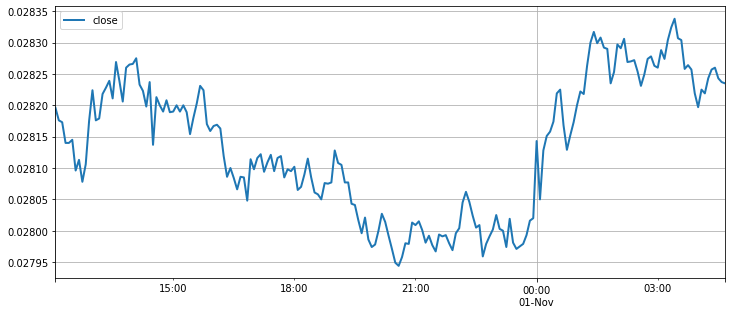

In [11]:
#
# Load model and define test data and variables to visually evaluate the model
#

import pandas as pd
from gluonts.model.predictor import Predictor
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

#TODO: Use deepar.model_fn?
# model_output_dir_path is basically the same path as it was before, though sagemaker appends a random temp directory
#  to the path. The path from TRAIN includes that random temp directory
model_output_dir_path = TRAIN.model_dir_path.parent.parent / "model"
predictor = Predictor.deserialize(Path(model_output_dir_path))

test_dataset_filename = dataset_dir_path / conf.TEST_DATASET_FILENAME
df = pd.read_csv(filepath_or_buffer=test_dataset_filename, header=0, index_col=0)

test_data = ListDataset(
    [{"start": df.index[0], "target": df['close'][:]}],
    freq="5min"
)

to_pandas(next(iter(test_data)))[:200].plot(figsize=(12, 5), linewidth=2)
plt.grid()
plt.legend(["close"])
plt.show()

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 100
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

Number of sample paths: 1000
Dimension of samples: (1000, 13)
Start date of the forecast window: 2021-03-10 23:05:00
Frequency of the time series: 5min


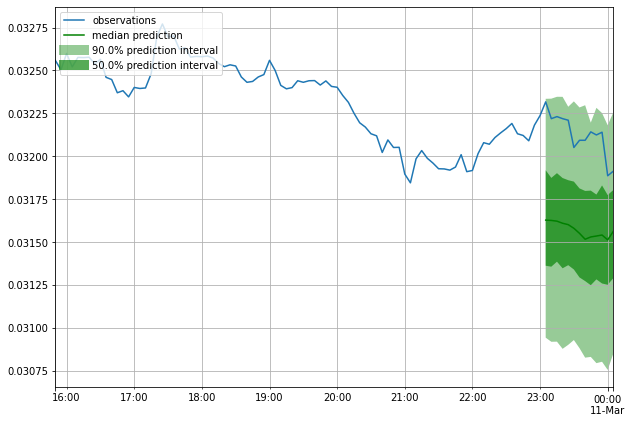

In [14]:
#
# Visually evaluate the model by graphing some prediction test results
#

from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
forecast_entry = forecasts[0]
tss = list(ts_it)
ts_entry = tss[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

plot_prob_forecasts(tss[0], forecasts[0])

In [ ]:
#
# NOTE: FURTHER CELLS ARE COMPATIBLE WITH AWS SAGEMAKER ONLY, LOCAL MODE WILL NOT WORK
# Hyperparameter tune the model
#

from ml.tune import Tune

TUNE = Tune(LOGGER)

train_dataset_uri = f"{dataset_dir_uri}/{PARSE.TRAIN_DATASET_FILENAME}"
test_dataset_uri = f"{dataset_dir_uri}/{PARSE.TEST_DATASET_FILENAME}"

tuner = TUNE.create_tuner(estimator)
TUNE.fit_tuner(tuner, train_dataset_uri, test_dataset_uri)

In [ ]:
#
# Get updates for Hyperparameter tune job. Ensure this is completed before going to the next cell
#

TUNE.get_tune_job_update()

In [ ]:
#
# Evaluate the metrics of the tune job
#

TUNE.report_job_analytics()
